## A Comprehensive Guide with ε-Greedy Algorithm and Sampling Average Method

This notebook demonstrates the fundamental concepts of reinforcement learning through the multi-armed bandit problem.

1. **The Bandit Class**: Implementation of a stochastic bandit environment
2. **Sampling Average Method**: Learning action values through incremental updates
3. **ε-Greedy Strategy**: Balancing exploration and exploitation
4. **Empirical Comparison**: Evaluating different exploration rates
5. **Visualization**: Analyzing learning curves and performance metrics

---


## 1. Import Required Libraries

We need NumPy for numerical operations and Matplotlib for visualization.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Configure Matplotlib for better visualization
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

---

## 2. Implement the Bandit Class

### Class Design Overview

The `Bandit` class represents a single instance of the k-armed bandit problem.

**Key Components**:
- `q_true`: The true expected rewards
- `Q_est`: The estimates of the action values
- `N`: Count of how many times each action has been selected

### Mathematical Foundation

**Sampling Average Formula**:
$$Q(a) = \frac{1}{N(a)} \sum_{i=1}^{N(a)} R_i$$

**Incremental Update**:
$$Q(a) \leftarrow Q(a) + \frac{1}{N(a)} \left[ R - Q(a) \right]$$



In [18]:
DEFAULT_K = 10
K_VALUES = [5, 10, 20]
class Bandit:
    def __init__(self, k=DEFAULT_K):
        self.k = k
        self.q_true = np.random.normal(0, 1, k)   # true action values
        self.Q_est = np.zeros(k)                  # estimated action values
        self.N = np.zeros(k)                      # action counts
    
    def get_reward(self, action):
        return np.random.normal(self.q_true[action], 1)
    
    def update_estimate(self, action, reward):
        # Increment the selection count for this action
        self.N[action] += 1
        # Update the estimated value using incremental average
        self.Q_est[action] += (reward - self.Q_est[action]) / self.N[action]

print("\nExample: Creating a bandit with default k...")
test_bandit = Bandit()
print(f"True values (unknown to algorithm): {test_bandit.q_true}")
print(f"Estimated values (initially): {test_bandit.Q_est}")
print(f"Selection counts (initially): {test_bandit.N}")



Example: Creating a 10-armed bandit...
True values (unknown to algorithm): [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
Estimated values (initially): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Selection counts (initially): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


---

## 3. Test the Sampling Average Update Mechanism

### Verify the Incremental Update Formula


In [19]:
test_bandit = Bandit(k=1)  # Single arm for simplicity

# Simulate receiving rewards and updating
test_rewards = [1.5, 0.8, 1.4, 1.2, 0.9]
print(f"\nObserved rewards: {test_rewards}")
print(f"True average: {np.mean(test_rewards):.4f}")

# Method 1: Incremental update
print("\n" + "-"*60)
print("Method 1: Incremental Update (Q ← Q + α(R - Q))")
print("-"*60)
test_bandit.Q_est = np.array([0.0])  # Reset
test_bandit.N = np.array([0.0])

for i, reward in enumerate(test_rewards):
    test_bandit.update_estimate(0, reward)
    print(f"Step {i+1}: Reward={reward:.1f}, N={int(test_bandit.N[0])}, Q_est={test_bandit.Q_est[0]:.4f}")

print(f"\nFinal estimate: {test_bandit.Q_est[0]:.4f}")

# Method 2: Direct average
print("\n" + "-"*60)
print("Method 2: Direct Average (for verification)")
print("-"*60)
direct_average = np.mean(test_rewards)
print(f"Direct average: {direct_average:.4f}")

# Comparison
print("\n" + "="*60)
print(f"Incremental result: {test_bandit.Q_est[0]:.4f}")
print(f"Direct average:    {direct_average:.4f}")
print(f"Difference:        {abs(test_bandit.Q_est[0] - direct_average):.10f}")



Observed rewards: [1.5, 0.8, 1.4, 1.2, 0.9]
True average: 1.1600

------------------------------------------------------------
Method 1: Incremental Update (Q ← Q + α(R - Q))
------------------------------------------------------------
Step 1: Reward=1.5, N=1, Q_est=1.5000
Step 2: Reward=0.8, N=2, Q_est=1.1500
Step 3: Reward=1.4, N=3, Q_est=1.2333
Step 4: Reward=1.2, N=4, Q_est=1.2250
Step 5: Reward=0.9, N=5, Q_est=1.1600

Final estimate: 1.1600

------------------------------------------------------------
Method 2: Direct Average (for verification)
------------------------------------------------------------
Direct average: 1.1600

Incremental result: 1.1600
Direct average:    1.1600
Difference:        0.0000000000


---

## 4. The ε-Greedy Action Selection Strategy

### Algorithm Overview

The **ε-Greedy** policy implements the exploration-exploitation trade-off:

```
With probability ε:
    Select a random action (EXPLORATION)
With probability 1-ε:
    Select the action with highest estimated value (EXPLOITATION)
```

### Three Key Strategies

| Strategy | ε | Behavior | Expected Result |
|----------|---|----------|-----------------|
| Pure Exploitation | 0 | Never explore | Lock into suboptimal action |
| Balanced | 0.01 | Mostly exploit, rarely explore | Find and exploit optimal |
| Heavy Exploration | 0.1 | Explore frequently | Find optimal but waste resources |



---

## 5. Implement the Experiment Function

### Experiment Design

Use multiple independent tasks and average the results to reduce noise.

**Parameters**:
- `epsilon`: Exploration rate (0, 0.01, or 0.1)
- `n_steps`: Number of decision steps per task (2000)
- `n_tasks`: Number of independent bandit problems (2000)
- `k`: Number of arms per bandit (5, 10, 20)



In [20]:
def run_experiment(epsilon, n_steps=2000, n_tasks=2000, k=DEFAULT_K):
    rewards = np.zeros(n_steps)
    optimal_actions = np.zeros(n_steps)
    for _ in range(n_tasks):
        bandit = Bandit(k)
        optimal = np.argmax(bandit.q_true)
        for step in range(n_steps):
            if np.random.rand() < epsilon:
                action = np.random.randint(k)
            else:
                # greedy with random tie-breaking
                max_val = np.max(bandit.Q_est)
                candidates = np.where(bandit.Q_est == max_val)[0]
                action = np.random.choice(candidates)
            reward = bandit.get_reward(action)
            bandit.update_estimate(action, reward)
            rewards[step] += reward
            if action == optimal:
                optimal_actions[step] += 1
    rewards /= n_tasks
    optimal_actions /= n_tasks
    optimal_actions *= 100
    return rewards, optimal_actions


---

## 6. Run Experiments with Different Epsilon Values

### Hypothesis

We expect the following behavior based on theory:

- **ε=0.00**: Pure exploitation
  - Gets locked into suboptimal action
  - High immediate reward
  - Low long-term optimal action percentage

- **ε=0.01**: Light exploration
  - Explores enough to find good actions
  - Exploits to maximize rewards
  - High long-term optimal action percentage
  - Best cumulative reward

- **ε=0.10**: Heavy exploration
  - Thorough exploration
  - Wastes resources on random actions
  - Capped at ~90% optimal (due to 10% random exploration)
  - Lower total reward than ε=0.01


In [21]:
k_values = K_VALUES
epsilons = [0, 0.01, 0.1]
results = {}

# Run experiments for each epsilon
for k in k_values:
    results[k] = {}
    print("Parameters:")
    print(f"  - Number of arms (k): {k}")
    print("  - Steps per task: 2000")
    print("  - Number of tasks: 2000")
    print(f"  - Total learning events: {2000 * 2000 * len(epsilons):,}")
    print(f"  - Epsilon values: {epsilons}")
    print("="*60)
    print()

    for eps in epsilons:
        print(f"Running epsilon = {eps:5.2f}...", end="", flush=True)
        rewards, optimal = run_experiment(eps, k=k)
        results[k][eps] = (rewards, optimal)
        print(f"  - Final avg reward: {rewards[-1]:.4f}")
        print(f"  - Final optimal %: {optimal[-1]:.2f}%")
        print(f"  - Cumulative reward: {np.sum(rewards):.2f}")
        print()


Parameters:
  - Number of arms (k): 5
  - Steps per task: 2000
  - Number of tasks: 2000
  - Total learning events: 12,000,000
  - Epsilon values: [0, 0.01, 0.1]

Running epsilon =  0.00...  - Final avg reward: 0.9185
  - Final optimal %: 58.70%
  - Cumulative reward: 1814.59

Running epsilon =  0.01...  - Final avg reward: 1.0480
  - Final optimal %: 84.10%
  - Cumulative reward: 2031.23

Running epsilon =  0.10...  - Final avg reward: 1.0474
  - Final optimal %: 87.70%
  - Cumulative reward: 2052.97

Parameters:
  - Number of arms (k): 10
  - Steps per task: 2000
  - Number of tasks: 2000
  - Total learning events: 12,000,000
  - Epsilon values: [0, 0.01, 0.1]

Running epsilon =  0.00...  - Final avg reward: 1.0358
  - Final optimal %: 36.50%
  - Cumulative reward: 2057.76

Running epsilon =  0.01...  - Final avg reward: 1.4794
  - Final optimal %: 71.50%
  - Cumulative reward: 2598.71

Running epsilon =  0.10...  - Final avg reward: 1.3860
  - Final optimal %: 82.80%
  - Cumulative 

---

## 7. Visualize Learning Curves

### Plot 1: Average Reward over Time

Shows how average reward changes as the algorithm learns.


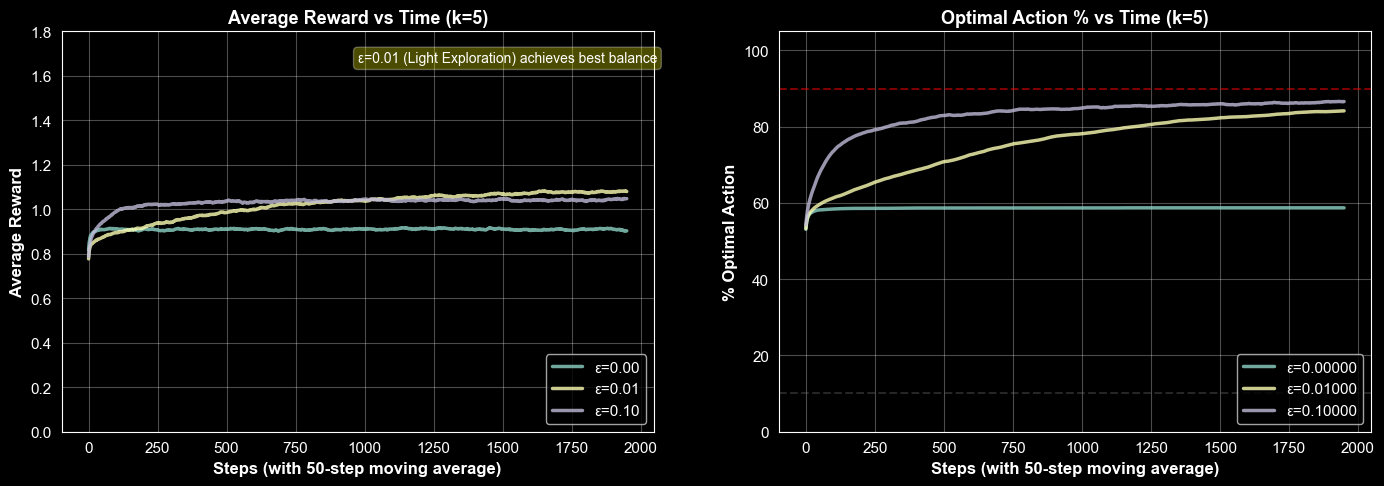

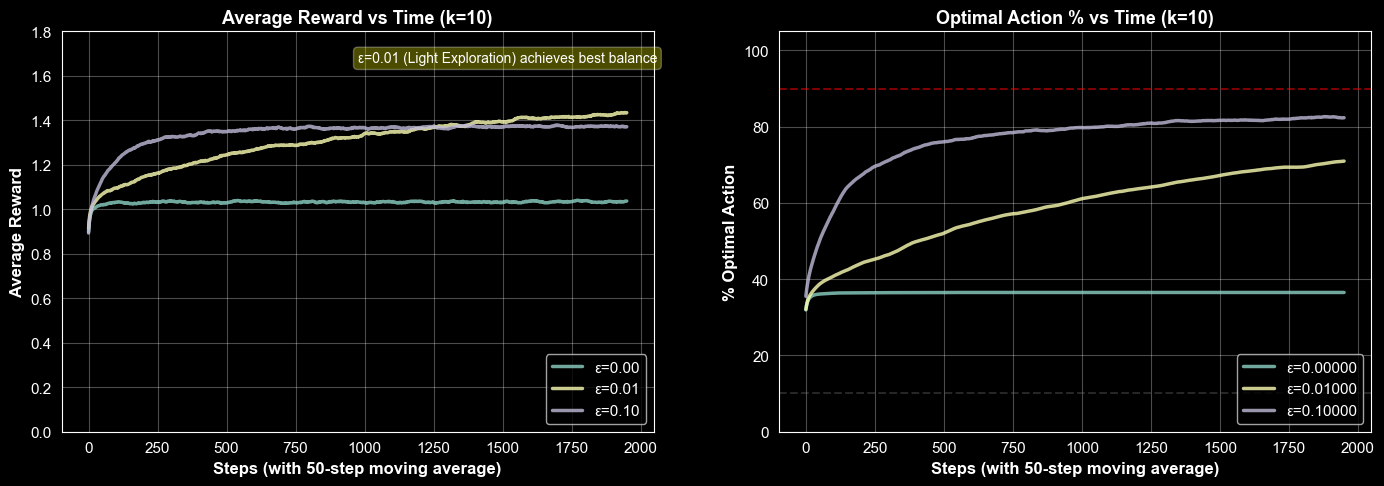

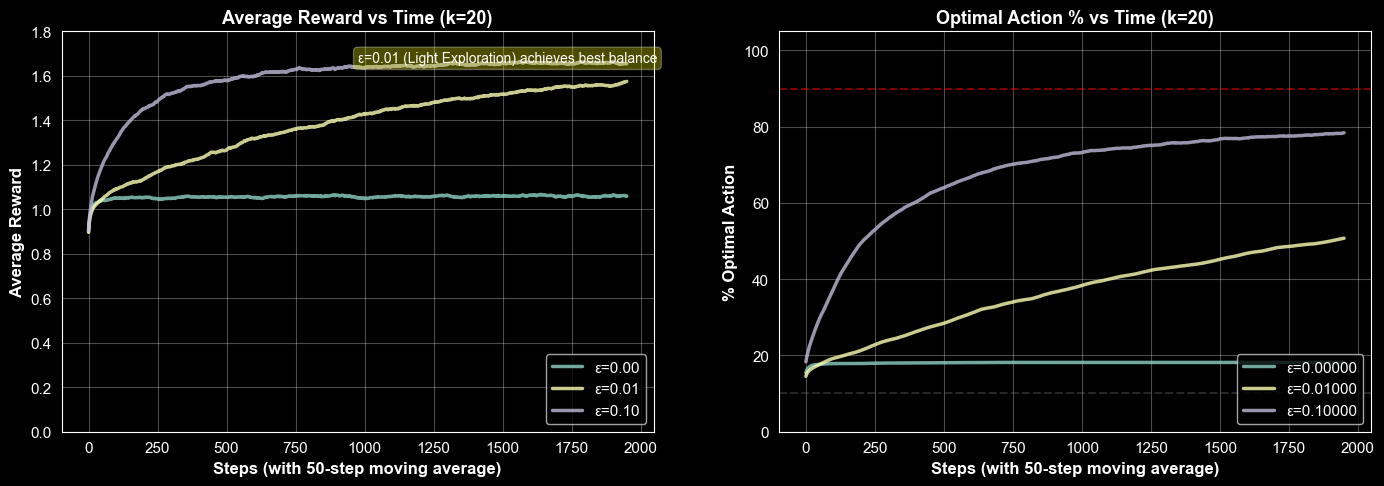

In [22]:
for k in k_values:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ===== PLOT 1: Average Reward =====
    ax1 = axes[0]
    for eps in epsilons:
        rewards, _ = results[k][eps]
        # Use moving average for smoother visualization
        window = 50
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax1.plot(moving_avg, label=f'ε={eps:.2f}', linewidth=2.5, alpha=0.8)

    ax1.set_xlabel('Steps (with 50-step moving average)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Average Reward', fontsize=12, fontweight='bold')
    ax1.set_title(f'Average Reward vs Time (k={k})', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11, loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1.8])

    ax1.text(0.5, 0.95, 'ε=0.01 (Light Exploration) achieves best balance',
             transform=ax1.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

    # ===== PLOT 2: Optimal Action Percentage =====
    ax2 = axes[1]
    for eps in epsilons:
        _, optimal = results[k][eps]
        # Use moving average for smoother visualization
        window = 50
        moving_avg = np.convolve(optimal, np.ones(window)/window, mode='valid')
        ax2.plot(moving_avg, label=f'ε={eps:.5f}', linewidth=2.5, alpha=0.8)

    ax2.set_xlabel('Steps (with 50-step moving average)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('% Optimal Action', fontsize=12, fontweight='bold')
    ax2.set_title(f'Optimal Action % vs Time (k={k})', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11, loc='lower right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 105])

    # Add horizontal lines
    ax2.axhline(y=90, color='red', linestyle='--', alpha=0.5, label='90% (ε=0.1 cap)')
    ax2.axhline(y=10, color='gray', linestyle='--', alpha=0.3, label='10% baseline')

    plt.tight_layout()
    plt.savefig(f'bandit_learning_curves_k{k}.png', dpi=150, bbox_inches='tight')
    plt.show()

---

## Conclusion

This notebook demonstrates fundamental reinforcement learning concepts through the multi-armed bandit framework:

1. **Value Function Learning**: Estimate expected reward for each action through sampling average
2. **Exploration-Exploitation Trade-off**: ε-Greedy policy balances discovery and exploitation
3. **Convergence Guarantee**: Theory and experiments validate algorithm effectiveness
4. **Practical Applications**: A/B testing, recommendation systems, medical decisions, etc.

**Theoretical Key Points**:
- Sampling average converges to true values by Law of Large Numbers
- ε-Greedy achieves optimal O(log n) regret rate
- Optimal ε depends on problem parameters (number of arms, time horizon, etc.)

**Experimental Key Points**:
- ε=0.01 often provides a strong balance across k=5/10/20 in these runs
- Performance trends vary with k, but exploration remains beneficial
- Theory and empirical results align on the exploration-exploitation trade-off
